### A dataviz demo showcasing graphs for "supports" in the Fire Emblem games.
### In the Fire Emblem (FE) games, characters can sometimes "support" each other. It can be interesting to visualize which characters can support each other at a glance.
### Here, we use a FE wiki page to scrape information regarding these supports, and create graphs from there.

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import community as community_louvain
import time

from matplotlib import pyplot as plt 
from pyvis.network import Network
from selenium import webdriver
from selenium.webdriver.common.by import By

In [2]:
GrandURL = "https://fireemblemwiki.org/wiki/Category:Lists_of_supports"
link_template = "List of supports in Fire Emblem"

In [3]:
# Open a webpage in Firefox, find all links of interest

driver = webdriver.Firefox()
driver.get(GrandURL)

time.sleep(3) # Let the page load
content = driver.find_elements(By.PARTIAL_LINK_TEXT, link_template)

In [4]:
# In example:

content[3].get_attribute('href')

'https://fireemblemwiki.org/wiki/List_of_supports_in_Fire_Emblem_Echoes:_Shadows_of_Valentia'

### The games we wish to create graphs for are not listed in a neat order by release date on the webpage.

### We are also only interested in making graphs for certain games.

### We take a few steps to sort extract the info we need from the games we want.

In [5]:
run = 0
for game in content:
    print(run, game.text)
    run+=1

0 List of supports in Fire Emblem Awakening
1 List of supports in Fire Emblem: The Binding Blade
2 List of supports in Fire Emblem: The Blazing Blade
3 List of supports in Fire Emblem Echoes: Shadows of Valentia
4 List of supports in Fire Emblem Engage
5 List of supports in Fire Emblem Fates
6 List of supports in Fire Emblem: Path of Radiance
7 List of supports in Fire Emblem: The Sacred Stones
8 List of supports in Fire Emblem: Three Houses
9 List of supports in Fire Emblem Warriors
10 List of supports in Fire Emblem Warriors: Three Hopes


In [6]:
GamesOfInterest = {
    "FE6" : 1,
    "FE7" : 2,
    "FE8" : 7,
    "FE9" : 6,
    "FE15" : 3,
    "FE16" : 8,
    "FE17" : 4
}

game_page_links =[]
for v in GamesOfInterest.values():
    game_title = content[v].text
    game_title = game_title.split(link_template)[1]
    game_title = game_title[game_title.find(" ")+1:]
    
    game_link = content[v].get_attribute('href')
    game_page_links.append(
        {"game_title": game_title, "url": game_link}
    )

In [7]:
game_page_links

[{'game_title': 'The Binding Blade',
  'url': 'https://fireemblemwiki.org/wiki/List_of_supports_in_Fire_Emblem:_The_Binding_Blade'},
 {'game_title': 'The Blazing Blade',
  'url': 'https://fireemblemwiki.org/wiki/List_of_supports_in_Fire_Emblem:_The_Blazing_Blade'},
 {'game_title': 'The Sacred Stones',
  'url': 'https://fireemblemwiki.org/wiki/List_of_supports_in_Fire_Emblem:_The_Sacred_Stones'},
 {'game_title': 'Path of Radiance',
  'url': 'https://fireemblemwiki.org/wiki/List_of_supports_in_Fire_Emblem:_Path_of_Radiance'},
 {'game_title': 'Echoes: Shadows of Valentia',
  'url': 'https://fireemblemwiki.org/wiki/List_of_supports_in_Fire_Emblem_Echoes:_Shadows_of_Valentia'},
 {'game_title': 'Three Houses',
  'url': 'https://fireemblemwiki.org/wiki/List_of_supports_in_Fire_Emblem:_Three_Houses'},
 {'game_title': 'Engage',
  'url': 'https://fireemblemwiki.org/wiki/List_of_supports_in_Fire_Emblem_Engage'}]

### We start with FE6: The Binding Blade.
### The lxml optional dependancy is required.

In [8]:
# !pip install lxml

support_table = pd.read_html(game_page_links[0]['url'])
support_table = support_table[1]
support_table = support_table.T
support_table.columns = support_table.iloc[0]
support_table = support_table.drop("Character")
support_table

Character,Roy,Marcus,Alen,Lance,Wolt,Bors,Elen,Dieck,Ward,Lot,...,Garret,Fae,Hugh,Zeiss,Douglas,Niime,Juno,Dayan,Yoder,Karel
1,Marcus,Roy,Roy,Roy,Roy,Astolfo,Chad,Ward,Alen,Lance,...,Lilina,Sue,Chad,Elen,Geese,Raigh,Shanna,Rutger,Saul,Rutger
2,Alen,Alen,Marcus,Marcus,Marcus,Lilina,Lugh,Lot,Dieck,Dieck,...,Geese,Elffin,Lugh,Sin,Larum,Sophia,Zelot,Sue,Dorothy,Noah
3,Lance,Lance,Lance,Alen,Alen,Barthe,Saul,Shanna,Lot,Ward,...,Gonzalez,Sophia,Raigh,Bartre,Elffin,Fae,Trec,Sin,Melady,Fir
4,Wolt,Wolt,Wolt,Wolt,Lance,Ogier,Melady,Clarine,Shanna,Shanna,...,Larum,Igrene,Cath,Melady,Cecilia,Hugh,Noah,Gonzalez,Niime,Bartre
5,Shanna,Lilina,Ward,Lot,Sue,Gwendolyn,Zeiss,Rutger,Echidna,Echidna,...,Cath,Niime,Niime,Karel,Igrene,Yoder,Thea,Yoder,Dayan,Zeiss
6,Sue,--,Thea,Clarine,--,--,--,Klein,--,--,...,--,--,--,--,Perceval,--,--,--,--,--
7,Lilina,--,--,--,--,--,--,--,--,--,...,--,--,--,--,--,--,--,--,--,--
8,Larum,--,--,--,--,--,--,--,--,--,...,--,--,--,--,--,--,--,--,--,--
9,Cecilia,--,--,--,--,--,--,--,--,--,...,--,--,--,--,--,--,--,--,--,--
10,Sophia,--,--,--,--,--,--,--,--,--,...,--,--,--,--,--,--,--,--,--,--


### To create nodes for a graph, we neet a source and a target, e.g. (Roy, Marcus).
### Roy has supports with many characters (Marcus, Alen, etc.), while Marcus has fewer.
### All supports are two-way, meaning Roy supports Marcus and Marcus supports Roy, etc.

In [9]:
individual_supports = []
for character in support_table.columns:
    for friend in support_table[character]:
        if friend != "--":
            individual_supports.append({"Source": character, "Target": friend})

individual_supports = pd.DataFrame(individual_supports)

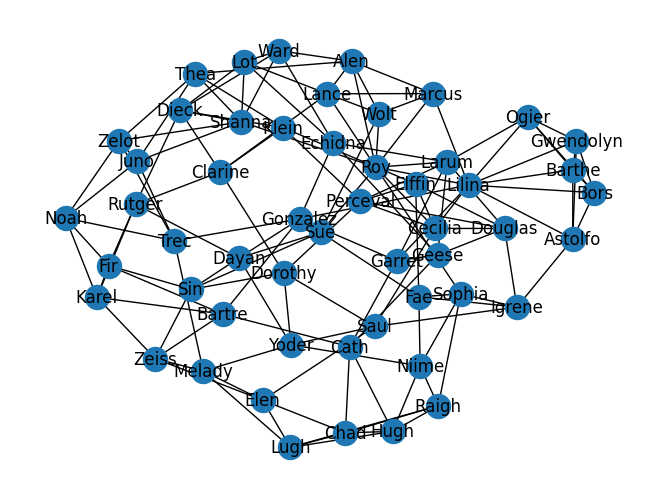

In [10]:
FE6_graph = nx.from_pandas_edgelist(individual_supports,
                                    source="Source", target="Target",
                                    create_using=nx.Graph())
pos = nx.kamada_kawai_layout(FE6_graph)
nx.draw(FE6_graph, with_labels=True, pos=pos)
#plt.show()

### The above graph looks gross, so the nice versions will be .png files lokated in this same directory.

In [11]:
# These are som centrality measures to hopefully make the graph look nicer.

node_degree = dict(FE6_graph.degree)
degree_dict = nx.degree_centrality(FE6_graph)
betweenness_dict = nx.betweenness_centrality(FE6_graph)
closeness_dict = nx.closeness_centrality(FE6_graph)

nx.set_node_attributes(FE6_graph, node_degree, 'size')
nx.set_node_attributes(FE6_graph, degree_dict, 'degree_centrality')
nx.set_node_attributes(FE6_graph, betweenness_dict, 'betweenness_centrality')
nx.set_node_attributes(FE6_graph, closeness_dict, 'closeness_centrality')

communities = community_louvain.best_partition(FE6_graph)
nx.set_node_attributes(FE6_graph, communities, 'group')

In [12]:
net = Network(notebook=True, width="600px", height="600px",cdn_resources='remote')
net.from_nx(FE6_graph)
net.show("FE6.html")

FE6.html


### The above code produces a .html file, which I save as a .png file since VSCode has trouble viewing .html files.

### For the rest of this demo, we have re-factored some of the above code into funcitons to make prducing the graphs for the other games easier.

### We chose to do it this way instead of defining the funcitons above because the jupyter notebook format is easier to follow as a step-by-step document of sorts. This is a redundant way to write code, but the code is easier to read this way, and we prioritize presentation with this demo over funcitonality.

### The remaining games follow.

In [13]:
import FE_helpers as h

In [14]:
game_page_links

[{'game_title': 'The Binding Blade',
  'url': 'https://fireemblemwiki.org/wiki/List_of_supports_in_Fire_Emblem:_The_Binding_Blade'},
 {'game_title': 'The Blazing Blade',
  'url': 'https://fireemblemwiki.org/wiki/List_of_supports_in_Fire_Emblem:_The_Blazing_Blade'},
 {'game_title': 'The Sacred Stones',
  'url': 'https://fireemblemwiki.org/wiki/List_of_supports_in_Fire_Emblem:_The_Sacred_Stones'},
 {'game_title': 'Path of Radiance',
  'url': 'https://fireemblemwiki.org/wiki/List_of_supports_in_Fire_Emblem:_Path_of_Radiance'},
 {'game_title': 'Echoes: Shadows of Valentia',
  'url': 'https://fireemblemwiki.org/wiki/List_of_supports_in_Fire_Emblem_Echoes:_Shadows_of_Valentia'},
 {'game_title': 'Three Houses',
  'url': 'https://fireemblemwiki.org/wiki/List_of_supports_in_Fire_Emblem:_Three_Houses'},
 {'game_title': 'Engage',
  'url': 'https://fireemblemwiki.org/wiki/List_of_supports_in_Fire_Emblem_Engage'}]

In [15]:
# FE7: The Blazing Blade

FE7_supports, FE7_individuals = h.make_support_table(game_page_links[1]['url'])
#FE7_supports

FE7.html


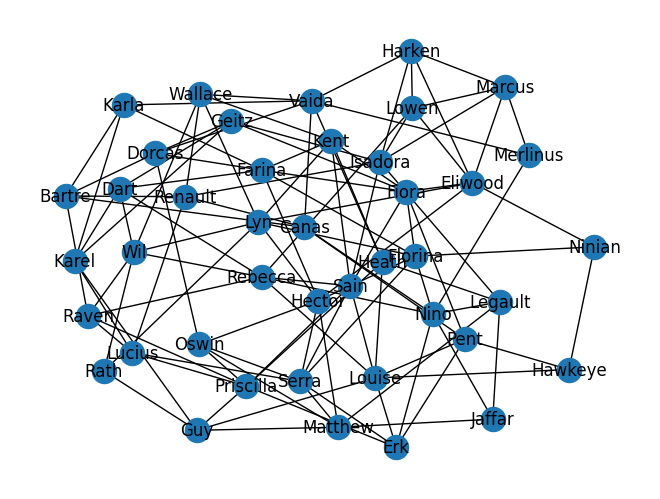

In [16]:
FE7_graph = nx.from_pandas_edgelist(FE7_individuals,
                                    source="Source", target="Target",
                                    create_using=nx.Graph())
h.grand_graph_draw(FE7_graph, "FE7.html")

In [17]:
# FE8: The Sacred Stones

FE8_supports, FE8_individuals = h.make_support_table(game_page_links[2]['url'])
#FE8_supports

FE8.html


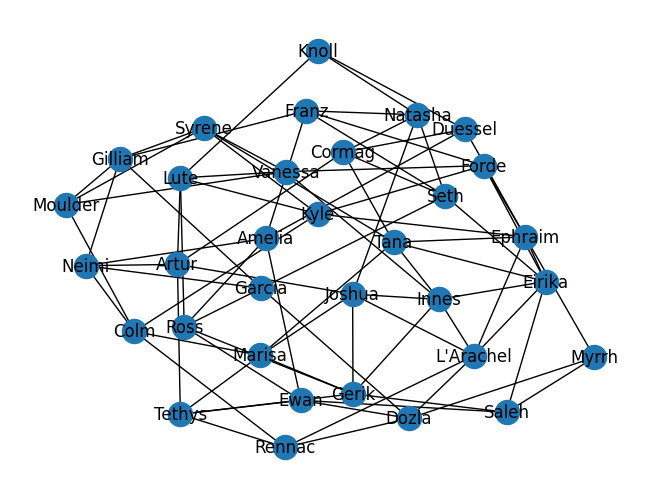

In [18]:
FE8_graph = nx.from_pandas_edgelist(FE8_individuals,
                                    source="Source", target="Target",
                                    create_using=nx.Graph())
h.grand_graph_draw(FE8_graph, "FE8.html")

In [19]:
# FE9: Path of Radiance

FE9_supports, FE9_individuals = h.make_support_table(game_page_links[3]['url'])
#FE9_supports

FE9.html


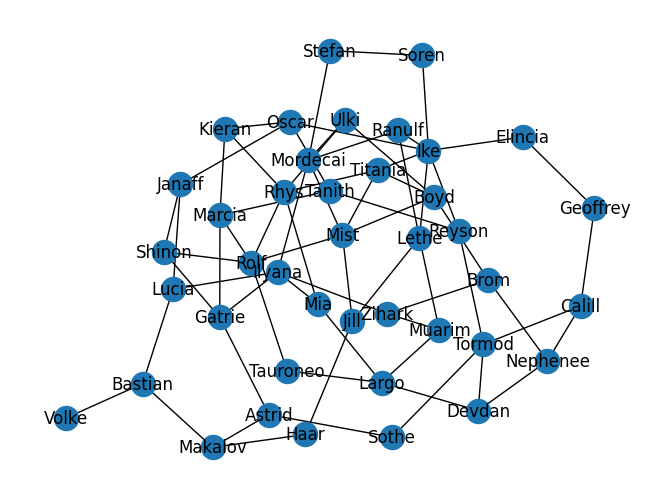

In [20]:
FE9_graph = nx.from_pandas_edgelist(FE9_individuals,
                                    source="Source", target="Target",
                                    create_using=nx.Graph())
h.grand_graph_draw(FE9_graph, "FE9.html")

In [21]:
# FE15: Shadows of Valentia

FE15_supports, FE15_individuals = h.make_support_table(game_page_links[4]['url'])
#FE15_supports

### FE15 actually needs more work. The wiki webpage includes more supports in a separate table, so the above dataframe is missing data. The code here is mostly the same as before.

### Additionally, FE15 has another mechanic called "bonds," which are almost the same as supports. Celica has a bond with Alm but not a support, and so we create graphs for supports and bonds.

In [22]:
temp = pd.read_html(game_page_links[4]['url'])
supp2, bonds = temp[2], temp[3]
supp2, bonds = supp2.T, bonds.T
supp2.columns, bonds.columns = supp2.iloc[0], bonds.iloc[0]
supp2, bonds = supp2.drop("Character"), bonds.drop("Character")

FE15_supports = FE15_supports.T.merge(supp2.T, on='Character', how='outer')
FE15_supports = FE15_supports.T

In [23]:
FE15_individuals = []
for character in FE15_supports.columns:
    for friend in FE15_supports[character]:
        if friend != "--":
            FE15_individuals.append({"Source": character, "Target": friend})
FE15_individuals = pd.DataFrame(FE15_individuals).dropna()

In [24]:
bonds_nodes =[]
for character in bonds:
    for friend in bonds[character]:
        if friend != "--":
            bonds_nodes.append({"Source": character, "Target": friend})
FE15_bonds = pd.DataFrame(bonds_nodes)

In [25]:
FE15_supp_graph = nx.from_pandas_edgelist(FE15_individuals,
                                    source="Source", target="Target",
                                    create_using=nx.Graph())
FE15_bonds_graph = nx.from_pandas_edgelist(FE15_bonds,
                                    source="Source", target="Target",
                                    create_using=nx.Graph())

FE15.html


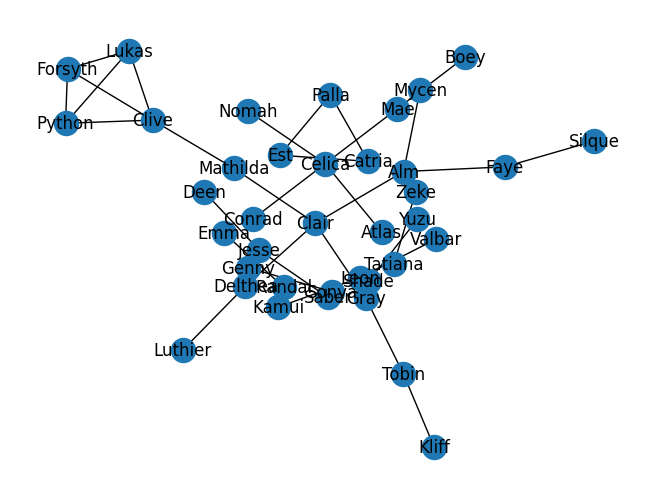

In [26]:
h.grand_graph_draw(FE15_supp_graph, "FE15.html")

FE15_bonds.html


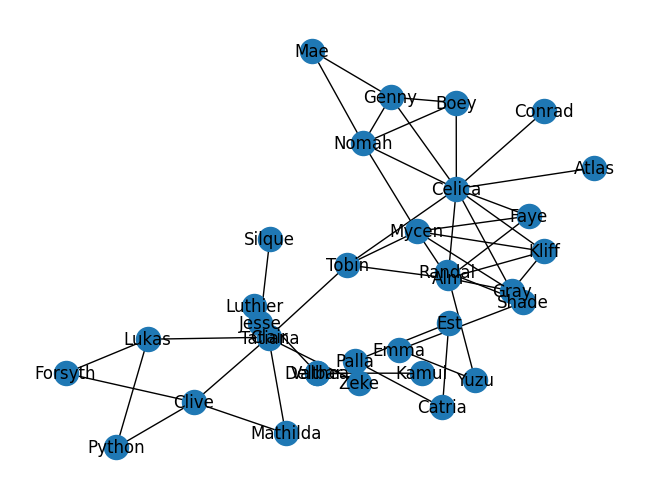

In [27]:
h.grand_graph_draw(FE15_bonds_graph, "FE15_bonds.html")

In [28]:
# FE16: Three Houses
# FE16 needs a little more cleaning as well, though not as much as FE15

FE16_supports, FE16_individuals = h.make_support_table(game_page_links[5]['url'])
FE16_supports = FE16_supports.T.dropna().T
FE16_individuals = FE16_individuals.dropna()
#FE16_supports

In [35]:
temp = pd.read_html(game_page_links[5]['url'])[1].dropna()

In [36]:
temp

,Character,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,Byleth (M),Edelgard,Dimitri,Claude,Hubert,Ferdinand,Linhardt,Caspar,Bernadetta,Dorothea,Petra,Dedue,Felix,Ashe,Sylvain,Mercedes
1,Byleth (M),Annette,Ingrid,Lorenz,Raphael,Ignatz,Lysithea,Marianne,Hilda,Leonie,Seteth,Flayn,Hanneman,Manuela,Gilbert,Alois
2,Byleth (M),Catherine,Shamir,Cyril,Rhea,Sothis,Jeritza,Yuri,Balthus,Constance,Hapi,--,--,--,--,--
3,Byleth (F),Edelgard,Dimitri,Claude,Hubert,Ferdinand,Linhardt,Caspar,Bernadetta,Dorothea,Petra,Dedue,Felix,Ashe,Sylvain,Mercedes
4,Byleth (F),Annette,Ingrid,Lorenz,Raphael,Ignatz,Lysithea,Marianne,Hilda,Leonie,Seteth,Flayn,Hanneman,Manuela,Gilbert,Alois
5,Byleth (F),Catherine,Shamir,Cyril,Rhea,Sothis,Jeritza,Yuri,Balthus,Constance,Hapi,--,--,--,--,--
6,Edelgard,Byleth (M),Byleth (F),Hubert,Ferdinand,Linhardt,Caspar,Bernadetta,Dorothea,Petra,Lysithea,Hanneman,Manuela,Constance,--,--
7,Dimitri,Byleth (M),Byleth (F),Dedue,Felix,Ashe,Sylvain,Mercedes,Annette,Ingrid,Raphael,Marianne,Flayn,Gilbert,Alois,Catherine
8,Dimitri,Hapi,--,--,--,--,--,--,--,--,--,--,--,--,--,--
9,Claude,Byleth (M),Byleth (F),Petra,Annette,Ingrid,Lorenz,Raphael,Ignatz,Lysithea,Marianne,Hilda,Leonie,Flayn,Shamir,Cyril


In [30]:
FE16_individuals[FE16_individuals.Source != FE16_individuals.Target]

,Source,Target
18,Edelgard,Byleth (M)
19,Edelgard,Byleth (F)
20,Edelgard,Hubert
21,Edelgard,Ferdinand
22,Edelgard,Linhardt
...,...,...
364,Hapi,Linhardt
365,Hapi,Ashe
366,Hapi,Yuri
367,Hapi,Balthus
